In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile
from matplotlib import pyplot
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# evaluate logistic regression fit on label propagation for semi-supervised learning
from numpy import concatenate
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelSpreading
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from numpy import concatenate
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn import datasets, metrics, model_selection, svm
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
file = tf.keras.utils
raw_features=pd.read_csv("https://media.githubusercontent.com/media/GuyenSoto/BTC/master/elliptic_txs_features.csv")
raw_classes=pd.read_csv("https://media.githubusercontent.com/media/GuyenSoto/BTC/master/elliptic_txs_classes.csv")
raw_edgelist=pd.read_csv("https://media.githubusercontent.com/media/GuyenSoto/BTC/master/elliptic_txs_edgelist.csv")


In [ ]:
#feat=raw_features.copy()
#clase=raw_classes.copy()
#edge=raw_edgelist.copy()

In [ ]:
raw_classes['class'].value_counts()

unknown    157205
2           42019
1            4545
Name: class, dtype: int64

In [ ]:
# renaming columns
raw_features.columns = ['id', 'time'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
raw_features.head()

,id,time,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,...,agg_feat_32,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,0.019771,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057392,0.058329,-0.032930,-0.042709,0.065455,0.324947,-0.139732,-0.148854,-0.080105,-0.155638,1.313051,1.106965,-0.139734,-0.148850,-0.080104,-0.155638,1.313130,1.106995,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.077909,-0.093120,1.587690,1.586539,-0.101820,0.704558,0.448898,0.659662,0.311091,0.302198,-1.373962,-1.355393,-0.300941,-1.404583,0.064846,-0.035232,-0.168742,-0.442156,-0.416540,-0.418273,0.367605,0.392035,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.1

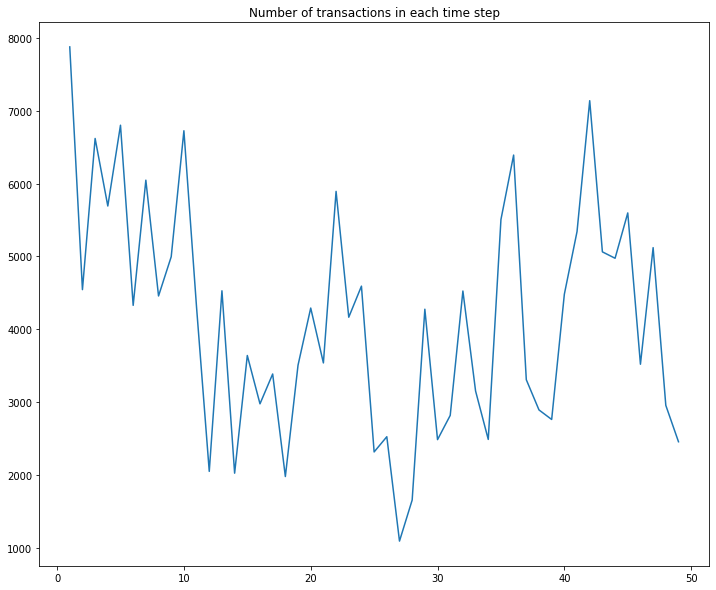

In [ ]:
raw_features['time'].value_counts().sort_index().plot();
plt.title('Number of transactions in each time step');

In [ ]:
# merge with classes
raw_features = pd.merge(raw_features, raw_classes, left_on='id', right_on='txId', how='left')


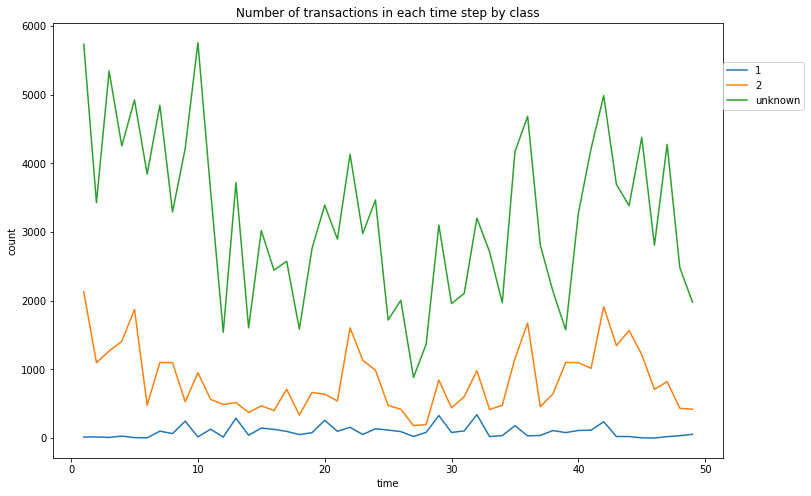

In [ ]:
plt.figure(figsize=(12, 8))
grouped = raw_features.groupby(['time', 'class'])['id'].count().reset_index().rename(columns={'id': 'count'})
sns.lineplot(x='time', y='count', hue='class', data=grouped);
plt.legend(loc=(1.0, 0.8));
plt.title('Number of transactions in each time step by class');

In [ ]:
raw_features.head()

,id,time,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,...,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,txId,class
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,5530458,unknown
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,232022460,unknown
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,232438397,2
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057392,0.058329,-0.032930,-0.042709,0.065455,0.324947,-0.139732,-0.148854,-0.080105,-0.155638,1.313051,1.106965,-0.139734,-0.148850,-0.080104,-0.155638,1.313130,1.106995,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,1.587690,1.586539,-0.101820,0.704558,0.448898,0.659662,0.311091,0.302198,-1.373962,-1.355393,-0.300941,-1.404583,0.064846,-0.035232,-0.168742,-0.442156,-0.416540,-0.418273,0.367605,0.392035,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.169472,-0.470592,-0.511871,-0.400422,

In [ ]:
raw_features=raw_features.rename(columns={"class":"Class"})

In [ ]:
cleaned_df = raw_features.copy()
# You don't want the `Time` column.
cleaned_df.pop('time')
# You don't want the `txId` column.
cleaned_df.pop('txId')
# You don't want the `id` column.
cleaned_df.pop('id')

0           5530458
1         232022460
2         232438397
3         230460314
4         230459870
            ...    
203763    173077460
203764    158577750
203765    158375402
203766    158654197
203767    157597225
Name: id, Length: 203768, dtype: int64

In [ ]:
cleaned_df['Class'].replace({"unknown": "-1"}, inplace=True)
cleaned_df['Class'].replace({"1": "1"}, inplace=True)
cleaned_df['Class'].replace({"2": "0"}, inplace=True)
cleaned_df['Class'] = pd.to_numeric(cleaned_df['Class'])

In [ ]:
#df["new_column"] = np.random.choice([1, 0], len(df), p=[0.7, 0.3])   #  0) First step
def rand_bin_array(K, N):
    arr = np.zeros(N,int)

    arr[:K]  = int( 1)
    np.random.shuffle(arr)
    return arr

In [ ]:
prueba_0=cleaned_df[cleaned_df['Class']==0] # 1) Split 0 array 
prueba_0

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,trans_feat_38,trans_feat_39,...,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,Class
2,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,0.026315,-0.227215,...,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
8,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,0.020069,-0.163135,1.696691,2.414968,-0.063200,-0.013282,2.370512,0.001525,-0.172908,0.221419,-0.243300,-0.243452,-0.139732,-0.147416,-0.079747,-0.155559,0.665165,1.037078,-0.139734,-0.147411,-0.079746,-0.155559,0.665251,1.037113,-0.024669,-0.031272,-0.023045,-0.026215,-0.973502,-0.973372,-0.227159,...,-0.124629,0.525309,0.617474,0.317264,-0.121020,-0.188716,-0.032710,-0.047722,-0.048171,-1.373902,-1.356289,-0.301754,-1.404621,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,0
9,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,-0.049707,-0.140266,-0.028741,-0.035391,-0.042955,-0.013282,-0.006754,-0.148916,-0.151494,-0.146513,0.887058,0.884557,-0.139721,-0.148905,-0.080147,-0.155653,-0.010763,-0.012107,-0.139723,-0.148901,-0.080147,-0.155653,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.127462,0.003143,0.002426,-0.115680,-0.190199,-0.177836,-0.201578,1.064205,1.063787,-1.373932,-1.356183,-0.301411,-1.404577,-0.975738,-0.975237,-0.168742,-0.445357,-0.409015,-0.427594,-1.015963,-1.016230,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
10,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,-0.049707,-0.143847,-0.028741,-0.035391,-0.042955,-0.013282,-0.038424,-0.150266,-0.150457,-0.150661,0.887058,0.884557,-0.139722,-0.148906,-0.080147,-0.155654,-0.010763,-0.012107,-0.139724,-0.148902,-0.080147,-0.155654,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.127462,0.003143,0.002426,-0.107516,-0.190820,-0.180486,-0.200607,1.064205,1.063787,-1.373902,-1.348835,-0.282308,-1.400475,-0.975738,-0.975237,-0.168742,-0.454961,-0.420758,-0.436915,-1.015963,-1.016230,-0.968903,-1.943850,-1.059868,-1.678997

In [ ]:
prueba_1=cleaned_df[cleaned_df['Class']==1] # 1) Split 0 array 
prueba_1

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,trans_feat_38,trans_feat_39,...,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,Class
906,-0.172669,0.048298,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.163319,-0.169138,-0.049707,-0.165623,-0.028741,-0.035391,-0.042955,-0.013282,-0.056486,-0.170893,-0.172687,-0.175893,-1.373657,-1.371460,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227178,...,-0.121362,0.003143,0.002426,0.034682,-0.171766,-0.188716,-0.149358,-0.047722,-0.048171,-1.373812,-1.356210,-0.301754,-1.404533,0.183133,0.182748,0.060963,-0.386969,-0.424672,-0.301819,0.143001,0.142525,0.660117,-0.375715,-1.059868,0.142339,0.185597,0.185492,0.398638,-0.458316,-0.577099,-0.285627,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1
1360,-0.164417,0.048298,-1.201369,0.178180,-0.043875,0.222447,-0.061584,-0.163580,-0.164278,-0.022718,-0.164197,-1.353307,-0.770605,-0.042955,-0.013282,-0.056489,-0.162409,-0.162936,-0.166124,-1.373657,-1.371460,-0.139732,-0.148893,-0.080129,-0.155652,-1.191904,-0.815353,-0.139734,-0.148891,-0.080130,-0.155653,-1.272639,-0.815199,-0.024669,-0.026775,-0.007652,-0.025190,-0.476835,-3.127893,-0.227215,...,-0.120955,1.844668,0.797411,-0.091535,-0.103042,-0.072684,-0.096422,-1.159649,-1.160129,-1.373812,-1.264494,-0.062493,-1.353515,1.342003,1.340733,-0.126628,-0.429352,-0.405404,-0.399390,1.301966,1.301281,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.193143,-0.513559,-0.457532,-0.500080,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984,1
2717,-0.164272,0.048298,-1.201369,0.028105,-0.043875,0.054722,-0.061584,-0.163191,-0.163923,-0.016812,-0.162980,2.457052,2.415325,-0.042955,-0.013282,-0.056489,-0.162260,-0.162765,-0.165952,-1.373657,-1.371460,-0.139726,-0.148898,-0.080137,-0.155649,1.066243,1.326635,-0.139727,-0.148893,-0.080136,-0.155649,1.066325,1.326651,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227168,...,-0.124751,0.003143,0.002426,-0.065979,-0.103042,-0.078511,-0.091148,-1.159649,-1.160129,-1.373812,-1.349888,-0.285263,-1.401017,1.342003,1.340733,-0.126628,1.240965,1.637005,1.221865,1.301966,1.301281,1.203124,0.146997,-1.059868,0.749451,0.185597,0.185492,0.185597,1.585683,1.978649,1.757982,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1
2814,-0.168195,0.048298,-1.201369,-0.046932,-0.063725,-0.029140,-0.061584,-0.163574,-0.164695,-0.006824,-0.163500,2.459222,2.415325,-0.063200,-0.013282,0.011805,-0.166228,-0.172908,-0.164929,-0.243300,-0.243452,-0.139721,-0.148898,-0.080137,-0.155648,-2.700912,-2.689592,-0.139723,-0.148894,-0.080136,-0.155648,-2.700785,-2.689318,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227149,...,-0.129496,0.003143,0.002426,-0.085726,-0.193389,-0.188716,-0.199062,-0.047722,-0.048171,-1.373753,-1.356157,-0.301754,-1.404475,0.183133,0.182748,-0.161512,-0.455921,-0.424672,-0.435673,0.143001,0.142525,-0.425896,-1.421138,-1.0

In [ ]:
prueba=cleaned_df[cleaned_df['Class']==-1]  # 2) Split array -1
prueba

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,trans_feat_38,trans_feat_39,...,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,Class
0,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,-1
1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227178,...,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,-1
3,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057392,0.058329,-0.032930,-0.042709,0.065455,0.324947,-0.139732,-0.148854,-0.080105,-0.155638,1.313051,1.106965,-0.139734,-0.148850,-0.080104,-0.155638,1.313130,1.106995,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.093120,1.587690,1.586539,-0.101820,0.704558,0.448898,0.659662,0.311091,0.302198,-1.373962,-1.355393,-0.300941,-1.404583,0.064846,-0.035232,-0.168742,-0.442156,-0.416540,-0.418273,0.367605,0.392035,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.169472,-0.470592,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,-1
4,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,0.038305,0.816377,-0.108000,0.907577,0.517402,0.341693,-0.013282,-0.057392,0.060033,-0.010829,-0.048401,-0.243639,-0.534976,-0.139732,-0.148855,-0.080110,-0.155641,1.001646,0.591836,-0.139734,-0.148851,-0.080109,-0.155641,1.001728,0.591900,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.088827,0.003143,0.002426,-0.101046,0.704558,0.382060,0.272503,-0.433005,-0.492387,-1.373962,-1.354445,-0.300062,-1.404412,-0.108018,-0.357362,-0.168742,-0.441465,-0.415693,-0.419836,-0.330396,-0.236199,-0.968903,-0.375715,-0.498323,-1.592267

In [ ]:
prueba['Class']=rand_bin_array(15720,157204)  # 3) Change array -1  target with a relation 1/10  Ilicit-Licit

In [ ]:
vertical = pd.concat([prueba, prueba_0,prueba_1], axis=0) #4) Put together all changes

In [ ]:
vertical=vertical.sort_index()   # 5) Order again new field
vertical

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,trans_feat_38,trans_feat_39,...,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,Class
0,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227178,...,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,0
2,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,0.026315,-0.227215,...,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
3,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057392,0.058329,-0.032930,-0.042709,0.065455,0.324947,-0.139732,-0.148854,-0.080105,-0.155638,1.313051,1.106965,-0.139734,-0.148850,-0.080104,-0.155638,1.313130,1.106995,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.093120,1.587690,1.586539,-0.101820,0.704558,0.448898,0.659662,0.311091,0.302198,-1.373962,-1.355393,-0.300941,-1.404583,0.064846,-0.035232,-0.168742,-0.442156,-0.416540,-0.418273,0.367605,0.392035,-0.968903,-1.943850,-1.059868,-1.678997,0

In [ ]:
# Matcheo
data_t= vertical.copy()
data_t

,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,trans_feat_38,trans_feat_39,...,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71,Class
0,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227178,...,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,0
2,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,0.026315,-0.227215,...,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
3,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057392,0.058329,-0.032930,-0.042709,0.065455,0.324947,-0.139732,-0.148854,-0.080105,-0.155638,1.313051,1.106965,-0.139734,-0.148850,-0.080104,-0.155638,1.313130,1.106995,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,...,-0.093120,1.587690,1.586539,-0.101820,0.704558,0.448898,0.659662,0.311091,0.302198,-1.373962,-1.355393,-0.300941,-1.404583,0.064846,-0.035232,-0.168742,-0.442156,-0.416540,-0.418273,0.367605,0.392035,-0.968903,-1.943850,-1.059868,-1.678997,0

In [ ]:
# Using different sizes of Data
data_1=data_t.iloc[:50942,:]
data_2=data_t.iloc[50942:101884,:]
data_3=data_t.iloc[101884:152826  ,:]
data_4=data_t.iloc[ 152826:,:]
data=data_t.iloc[:50942,:] #Using 1/4 of Dataset and almost using 50Gb RAM y Colab incredible

In [ ]:
# Definir X,y
X = data.drop(['Class'], axis = 1).values
y = data["Class"].values

In [ ]:
len(X), len(y)

(50942, 50942)

Stating Semi-Supervised Learning With Label Spreading

In [ ]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=1, stratify=y)

In [ ]:
# split train into labeled and unlabeled
X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(X_train, y_train, test_size=0.50, random_state=1, stratify=y_train)

In [ ]:
# create the training dataset input
X_train_mixed = concatenate((X_train_lab, X_test_unlab))

In [ ]:
X_train_mixed

array([[-0.13818739, -0.18466755, -1.2013688 , ..., -0.09752359,
        -0.12061341, -0.11979246],
       [-0.16867208, -0.18466755, -1.2013688 , ..., -0.14059708,
         1.51969962,  1.52139948],
       [ 2.83902702, -0.1328975 , -1.2013688 , ..., -0.09752359,
        -0.12061341, -0.11979246],
       ...,
       [-0.15518308, -0.18887387,  0.46360923, ..., -0.09752359,
        -0.12061341, -0.11979246],
       [ 0.14353656, -0.15878252, -1.2013688 , ..., -0.0305204 ,
        -0.13316779,  0.08554236],
       [-0.1696605 , -0.19317596,  0.46360923, ..., -0.01137662,
        -1.76092643, -1.7609844 ]])

In [ ]:
# create "no label" for unlabeled data
nolabel = [0 for _ in range(len(y_test_unlab))]

In [ ]:
# recombine training dataset labels
y_train_mixed = concatenate((y_train_lab, nolabel))

In [ ]:
len(y_train_mixed) ,len(X_train_mixed)

(25471, 25471)

In [ ]:
def rbf_kernel_safe(X, Y=None, gamma=None): 

      X, Y = sklearn.metrics.pairwise.check_pairwise_arrays(X, Y) 
      if gamma is None: 
          gamma = 1.0 / X.shape[1] 

      K = sklearn.metrics.pairwise.euclidean_distances(X, Y, squared=True) 
      K *= -gamma 
      K -= K.max()
      np.exp(K, K)    # exponentiate K in-place 
      return K 
#LabelPropagation(kernel = rbf_kernel_safe, tol = 0.01, gamma = 20).fit(X, Y)


In [ ]:
# define model
model = LabelSpreading(max_iter=1000)

In [ ]:
# fit model on training dataset
model.fit(X_train_mixed, y_train_mixed)

LabelSpreading(alpha=0.2, gamma=20, kernel='rbf', max_iter=1000, n_jobs=None,
               n_neighbors=7, tol=0.001)

In [ ]:
# get labels for entire training dataset data
tran_labels = model.transduction_

In [ ]:
#Checking we don't have any more Class=-1
len(tran_labels[tran_labels==-1])

0

In [ ]:
# define supervised learning model
model2 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,penalty='l2',
                   multi_class='auto', n_jobs=None, random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model2 = LogisticRegression(max_iter=4000)

In [ ]:
# fit supervised learning model on entire training dataset
model2.fit(X_train_mixed, tran_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# make predictions on hold out test set
yhat = model2.predict(X_test)

In [ ]:
# calculate score for test set
score = accuracy_score(y_test, yhat)

In [ ]:
# summarize score
print('Accuracy: %.2f' % (score*100))

Accuracy: 91.32


In [ ]:
y_pred=yhat

In [ ]:
#Model Evaluation using Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[23258,     9],
       [ 2203,     1]])

Text(0.5, 257.44, 'Predicted label')

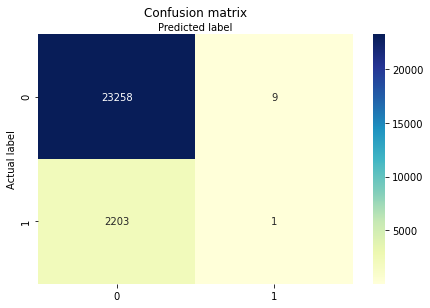

In [ ]:
#Visualizing Confusion Matrix using Heatmap
%matplotlib inline

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
#Confusion Matrix Evaluation Metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9131561383534216
Precision: 0.1
Recall: 0.00045372050816696913


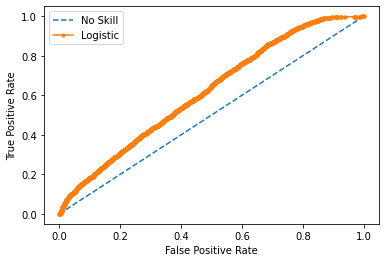

In [ ]:
# predict probabilities
yhat = model2.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, _ = roc_curve(y_test, pos_probs)
# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
def plot_precision_recall_curve(y_true, y_score, size=None):
    """plot_precision_recall_curve."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    if size is not None:
        plt.figure(figsize=(size, size))
        plt.axis('equal')
    plt.plot(recall, precision, lw=2, color='navy')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([-0.05, 1.05])
    plt.xlim([-0.05, 1.05])
    plt.grid()
    plt.title('Precision-Recall AUC={0:0.2f}'.format(average_precision_score(
        y_true, y_score))) 


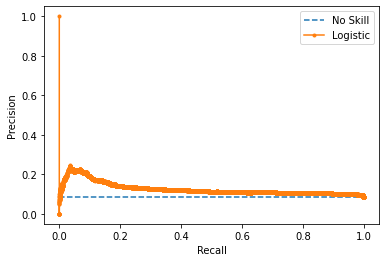

In [ ]:
# predict probabilities
yhat = model2.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

##We can see that the Precision, Recall and Accuracy are not performing well.

In [ ]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

y_pred=model2.predict_proba(X_test)
#If you want to predict e.g. 1 or 0 for your y values, then you would have to convert your linear regression predictions to either of these classes.
 #You could say any value in y_pred above 0.7 is a 1 and anything below is 0.

cutoff = 0.7                              # decide on a cutoff limit
y_pred_classes = np.zeros_like(y_pred)    # initialise a matrix full with zeros
y_pred_classes[y_pred > cutoff] = 1       # add a 1 if the cutoff was breached
#you have to do the same for the actual values too:

y_test_classes = np.zeros_like(y_pred)
y_test_classes[y_test > cutoff] = 1

#confusion_matrix(y_test_classes, y_pred_classes)
#F-1 and F-2 Score
score1=fbeta_score(y_test_classes, y_pred_classes, average=None, beta=1)
score2=fbeta_score(y_test_classes, y_pred_classes, average=None, beta=2)
print('F1-Measure:',score1[0],'F2-Measure:',score2[0])

F1-Measure: 0.15930867411505226 F2-Measure: 0.3214275292538446
